In [ ]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape, SeparableConv2D, add
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam, SGD
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(42)

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive/')
#!unzip gdrive/My\ Drive/Base_ovos/base.zip

In [ ]:
import skimage.io as io
from skimage.filters import threshold_otsu

names_orig = glob.glob('/content/mas/*.png')
names_mask = glob.glob('/content/mas/*.png')


X = []
Y = []
for name in names_orig:
  im_ori = io.imread(name)
  im_mask = io.imread('/content/mas/' + name.split('/')[-1])


  im_ori = im_ori.astype('float32') / 255 #normalizando a imagem entre 0 e 1

  im_mask = im_mask[:,:,0] #Pegando somente uma dimensao da mascara
  im_mask = im_mask.reshape(im_mask.shape[0],im_mask.shape[1],1) #Mudando de 255,255 para 255,255,1
  im_mask[im_mask[:,:,0] < 100] = 0 #Binarizando a mascara
  im_mask[im_mask[:,:,0] >= 100] = 1
  

  X.append(im_ori)
  Y.append(im_mask)

X = np.array(X)
Y = np.array(Y)

In [ ]:
#io.imshow(X[6].reshape(256,256,3))
#io.imshow(Y[6].reshape(256,256,1)[:,:,0])


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [ ]:
!pip install keras-unet

In [ ]:
from keras_unet.models import custom_unet

model = custom_unet(
    (256,256,3),
    filters=32,
    use_batch_norm=True,
    dropout=0.3,
    dropout_change_per_layer=0.0,
    num_layers=4
)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [ ]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def precision(y_true, y_pred):
    '''Calcula a precisão, uma métrica para classificação multi-rótulo de
     quantos itens selecionados são relevantes.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [ ]:
model.compile(optimizer="rmsprop", loss= ["binary_crossentropy"], metrics=[iou, dice_coef, precision, recall, accuracy])
hist = model.fit(x_train, y_train, epochs= 50, batch_size= 16, validation_split=0.1 , verbose=1)
    
model.save('model.h5')

Epoch 1/50
11/11 [==============================] - 10s 594ms/step - loss: 0.4643 - iou: 0.9986 - dice_coef: 0.1516 - precision: 0.2950 - recall: 0.9937 - accuracy: 0.8619 - val_loss: 8.7470 - val_iou: 0.9952 - val_dice_coef: 0.0962 - val_precision: 0.0438 - val_recall: 0.9997 - val_accuracy: 0.2115
Epoch 2/50
11/11 [==============================] - 3s 297ms/step - loss: 0.3451 - iou: 0.9991 - dice_coef: 0.1874 - precision: 0.6016 - recall: 0.9996 - accuracy: 0.9798 - val_loss: 1.3763 - val_iou: 0.9979 - val_dice_coef: 0.1521 - val_precision: 0.1467 - val_recall: 0.9996 - val_accuracy: 0.7846
Epoch 3/50
11/11 [==============================] - 3s 303ms/step - loss: 0.2931 - iou: 0.9993 - dice_coef: 0.2168 - precision: 0.6042 - recall: 0.9999 - accuracy: 0.9788 - val_loss: 1.1056 - val_iou: 0.9990 - val_dice_coef: 0.0223 - val_precision: 0.9174 - val_recall: 0.0718 - val_accuracy: 0.9661
Epoch 4/50
11/11 [==============================] - 3s 301ms/step - loss: 0.2522 - iou: 0.9995 - di

In [ ]:
pred_test = model.predict(x_test[0:10,:,:,:])

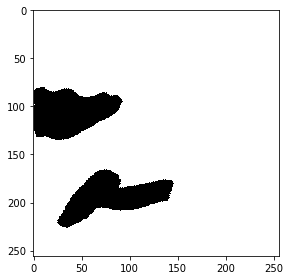

In [ ]:
#im = reescale(pred[3][:,:,0].reshape(256,256)) < 0.5
#im = reescale(pred_test[3][:,:,0].reshape(256,256)) < 0.5
i = 9

im = pred_test[8][:,:,0].reshape(256,256) < 0.5

#im = pred[3][:,:,0].reshape(256,256)
io.imshow(im)
#io.imshow(y_train[3][:,:,0])

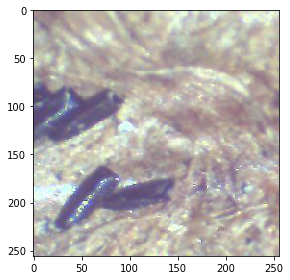

In [ ]:
io.imshow(x_test[8])

In [ ]:
def reescale(im):#Reescalando de 0 a 1 para 0 a 255
  OldMin = im.min()
  OldMax = im.max()
  NewMin = 0
  NewMax = 255

  OldRange = (OldMax - OldMin)  
  NewRange = (NewMax - NewMin)  

  return np.uint8((((im - OldMin) * NewRange) / OldRange) + NewMin)

In [ ]:
res = model.evaluate(x_test, y_test, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')

3/3 [==============================] - 4s 574ms/step - loss: 0.0282 - iou: 0.9999 - dice_coef: 0.7553 - precision: 0.8831 - recall: 0.8087 - accuracy: 0.9879
________________________
IOU:       |   99.99  |
Dice Coef: |   75.53  |
Precision: |   88.31  |
Recall:    |   80.87  |
Accuracy:  |   98.79  |
Loss:      |   2.82  |
________________________


In [ ]:
# DAQUI PRA BAIXO FORAM TENTATIVAS QUE NÃO DERAM CERTO

In [ ]:
num_classes = 2  

inputs = Input(shape=(256,256,3))

### [First half of the network: downsampling inputs] ###

# Entry block
x = Conv2D(32, 3, strides=2, padding="same")(inputs)
x = BatchNormalization()(x)
x = Activation("relu")(x)

previous_block_activation = x  # Set aside residual

# Blocks 1, 2, 3 are identical apart from the feature depth.
for filters in [64, 128, 256]:
    x = Activation("relu")(x)
    x = SeparableConv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)

    x = Activation("relu")(x)
    x = SeparableConv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = Conv2D(filters, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

### [Second half of the network: upsampling inputs] ###

for filters in [256, 128, 64, 32]:
    x = Activation("relu")(x)
    x = Conv2DTranspose(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)

    x = Activation("relu")(x)
    x = Conv2DTranspose(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(2)(x)

    # Project residual
    residual = UpSampling2D(2)(previous_block_activation)
    residual = Conv2D(filters, 1, padding="same")(residual)
    x = add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

# Add a per-pixel classification layer
outputs = Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

# Define the model
model = Model(inputs, outputs)

In [ ]:
#model.summary()

In [ ]:
model.compile(optimizer="rmsprop", loss= ["binary_crossentropy"])
hist = model.fit(x_train, y_train, epochs= 50, batch_size= 16, validation_split=0.1 , verbose=1)
    
model.save('model.h5')

Epoch 1/50
9/9 [==============================] - 33s 798ms/step - loss: 1.4324 - val_loss: 0.2091
Epoch 2/50
9/9 [==============================] - 2s 257ms/step - loss: 0.1550 - val_loss: 0.1806
Epoch 3/50
9/9 [==============================] - 2s 256ms/step - loss: 0.0977 - val_loss: 0.1747
Epoch 4/50
9/9 [==============================] - 2s 257ms/step - loss: 0.1822 - val_loss: 0.1246
Epoch 5/50
9/9 [==============================] - 2s 255ms/step - loss: 0.0792 - val_loss: 0.1240
Epoch 6/50
9/9 [==============================] - 2s 255ms/step - loss: 0.0969 - val_loss: 0.1249
Epoch 7/50
9/9 [==============================] - 2s 260ms/step - loss: 0.0725 - val_loss: 0.1203
Epoch 8/50
9/9 [==============================] - 2s 258ms/step - loss: 0.0920 - val_loss: 0.1399
Epoch 9/50
9/9 [==============================] - 2s 258ms/step - loss: 0.0706 - val_loss: 0.1217
Epoch 10/50
9/9 [==============================] - 2s 257ms/step - loss: 0.0822 - val_loss: 0.1226
Epoch 11/50
9/9 [=

In [ ]:
pred = model.predict(x_train[0:10,:,:,:])

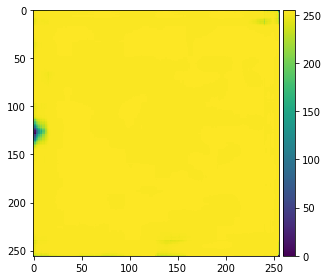

In [ ]:
im = reescale(pred[3][:,:,1].reshape(256,256)) #< 0.5

io.imshow(im)
#io.imshow(x_train[6])
#io.imshow(y_train[3][:,:,0])

In [ ]:
im = reescale(pred[3][:,:,1].reshape(256,256))

0

In [ ]:
def reescale(im):
  OldMin = im.min()
  OldMax = im.max()
  NewMin = 0
  NewMax = 255

  OldRange = (OldMax - OldMin)  
  NewRange = (NewMax - NewMin)  

  return np.uint8((((im - OldMin) * NewRange) / OldRange) + NewMin)

In [ ]:
######################################

In [ ]:
def segnet():

    # Encoding layer
    img_input = Input(shape= (256, 256, 3))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)

    #pred = Reshape((256,256,1))(x)
    
    model = Model(inputs=img_input, outputs=x)
    
    return model

In [ ]:
model = segnet()

model.compile(optimizer= SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False), loss= ["binary_crossentropy"])
model.summary()
hist = model.fit(x_train, y_train, epochs= 10, batch_size= 16, validation_split=0.1 , verbose=1)
    
model.save('segnet.h5')